# Wage Differences Within The STEM Occupation #

## Introduction ##

In recent years, both the consumer price index (CPI) and real gross domestic product (RGDP) have been increasing, indicating a boom in the economy (Canada, 2023). Therefore, we would also expect an increase in wages in all industries to a certain extent. Meanwhile, the rapid global growth in the field of Science, Technology, Engineering, and Mathematics (STEM) since 2020 globally has attracted many people to the industry (O’Rourke, 2021). Canada, being one of the more developed countries has also been greatly impacted. There has been an increase in students that are pursuing STEM. This leads us to the question we want to investigate: **Are hourly wages for workers with STEM occupations between ages 20-24 lower than workers between the ages of 40-44?** We will be looking at the Labour Force Survey, 2023 (LFS) data set from Statistic Canada. The survey was conducted in the first quarter of 2023 and includes information about the immigration status, hourly wage, field of occupation and other information of the workers. 

## Methods and Results ##

In [1]:
library(tidyverse)
library(broom)
library(repr)
library(digest)
library(infer)
require(gridExtra)

-- Attaching packages ------------------------------------------------------------------------------- tidyverse 1.3.1 --

v ggplot2 3.3.6      v purrr   0.3.4 
v tibble  3.1.8      v dplyr   1.0.10
v tidyr   1.2.0      v stringr 1.4.1 
v readr   2.1.2      v forcats 0.5.2 

Warning message:
"package 'ggplot2' was built under R version 4.1.3"
Warning message:
"package 'tibble' was built under R version 4.1.3"
Warning message:
"package 'tidyr' was built under R version 4.1.2"
Warning message:
"package 'readr' was built under R version 4.1.2"
Warning message:
"package 'dplyr' was built under R version 4.1.3"
Warning message:
"package 'stringr' was built under R version 4.1.3"
Warning message:
"package 'forcats' was built under R version 4.1.3"
-- Conflicts ---------------------------------------------------------------------------------- tidyverse_conflicts() --
x dplyr::filter() masks stats::filter()
x dplyr::lag()    masks stats::lag()

Warning message:
"package 'broom' was built under 

In [2]:
options(repr.plot.width=20, repr.plot.height=10) # Setting options

The following code imports the April 2023 Canadian Labour Force data into the notebook.

In [3]:
employment <- read_csv("https://raw.githubusercontent.com/GWilliam02/STAT201-Project/main/data/employmentData.csv")

Rows: 108064 Columns: 60
-- Column specification ------------------------------------------------------------------------------------------------
Delimiter: ","
chr  (7): SURVMNTH, AGE_12, NAICS_21, NOC_10, NOC_43, WHYLEFTN, EFAMTYPE
dbl (53): REC_NUM, SURVYEAR, LFSSTAT, PROV, CMA, AGE_6, SEX, MARSTAT, EDUC, ...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
employment_clean <- employment |>
                    select(NOC_10 ,HRLYEARN,AGE_12) |>
                    filter(!is.na(HRLYEARN)) |>
                    filter(NOC_10 == "03") |>    #Filters out everyone with STEM Occupations
                    filter(AGE_12=="02"|AGE_12=="06") |>
                    select(-NOC_10) |>
                    rename(age_group = AGE_12,
                          hourly_wage = HRLYEARN) |>
                    mutate(age_group = case_when(age_group == "02" ~ "20 to 24yr old",
                                                         age_group == "06" ~ "40 to 44 yr old")
                          ,hourly_wage = hourly_wage/100)
                    
                

head(employment_clean)

hourly_wage,age_group
<dbl>,<chr>
28.85,40 to 44 yr old
76.92,40 to 44 yr old
46.00,40 to 44 yr old
35.90,40 to 44 yr old
32.21,40 to 44 yr old
25.00,20 to 24yr old


**Table 1: Hourly wages and age group of an indvidual**

In [5]:
data_summary <- tibble(initial_dataframe_size = nrow(employment), size_after_cleaning = nrow(employment_clean))

summary_stats <- employment_clean |>
                group_by(age_group) |>
                summarize(count = n(), 
                         mean_wage = mean(hourly_wage),
                         sd = sd(hourly_wage),
                         variance = var(hourly_wage))
data_summary

initial_dataframe_size,size_after_cleaning
<int>,<int>
108064,806


**Table 2: Cleaned dataframe size**

The raw dataframe contained 108064 respondents in Canada where only 54289 participants had valid data on their hourly wages. Each row represents a single participant and their personal information and details on their employment. After data processing, 806 participants with STEM occupations with age groups 20-24 or 40-44 remain in the data set. Preliminary data analysis show a mean hourly wage of CAD 26.71 with a standard deviation of 7.94 for the 220 participants in age group 20-24. However, for the 586 participants in age group 40-44, the mean hourly wage is CAD 46.06 with a standard deviation of 16.69.

In [6]:
summary_stats

age_group,count,mean_wage,sd,variance
<chr>,<int>,<dbl>,<dbl>,<dbl>
20 to 24yr old,220,26.71486,7.937008,62.9961
40 to 44 yr old,586,46.05520,16.694721,278.7137


**Table 3: Summary Statistics of variables of interest**

Looking at the distributions, both groups are approximately unimodal and noramlly distributed, but each disitrbution is centred at a different mean. From this graph, the lowest earners within the 40-44 year old group make around the same as the highest earners from the 20-24 year old group. It is common for people in the 40-44 year old group to make between 30-60 dollars an hour.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



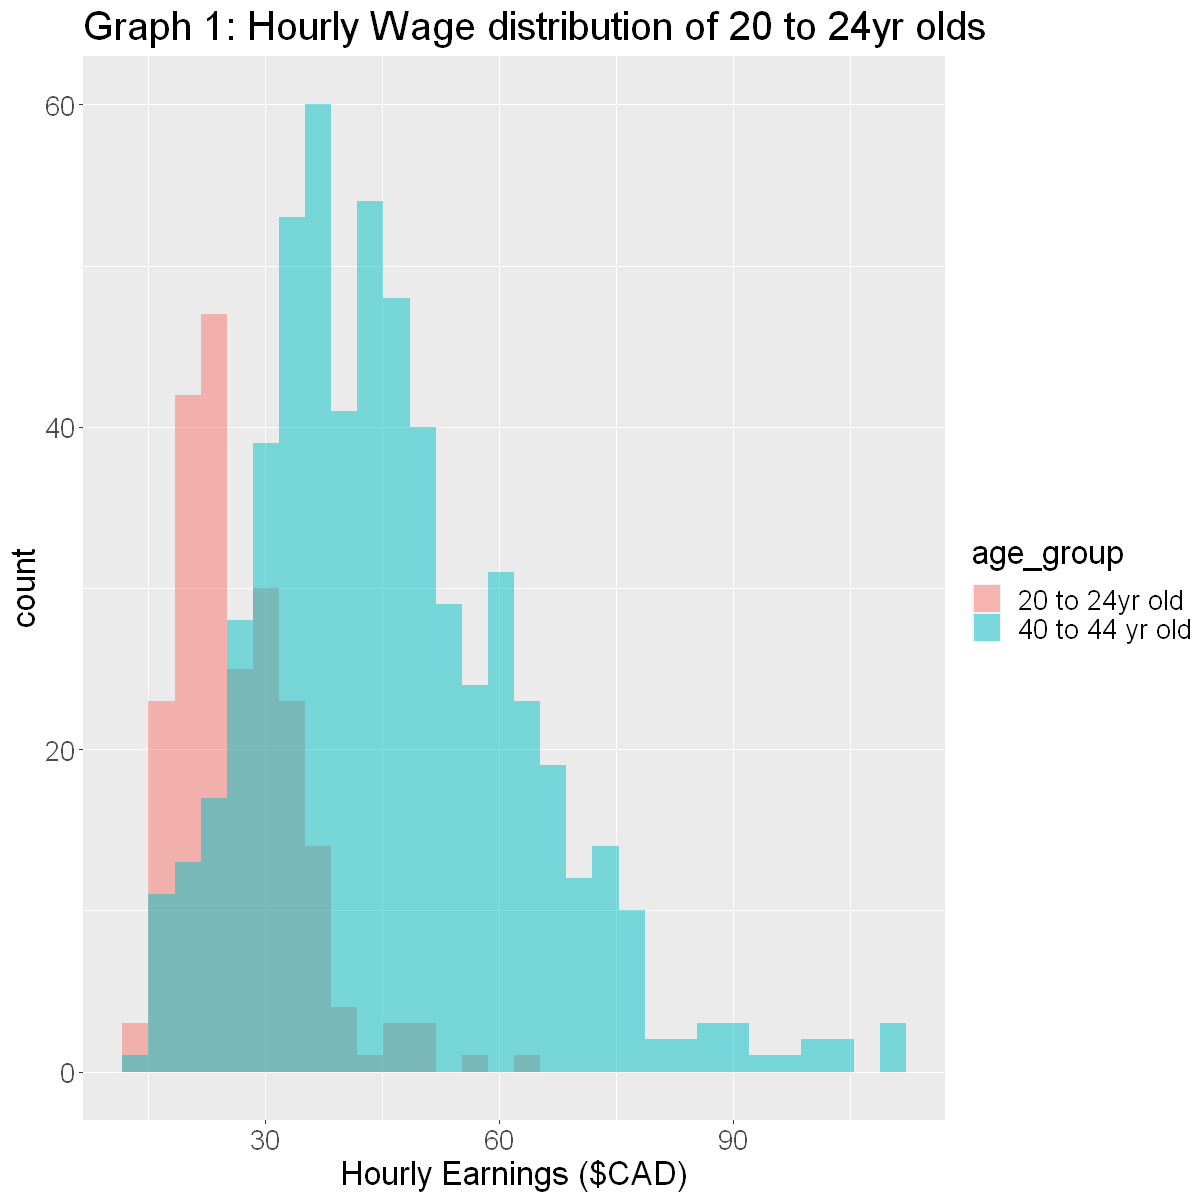

In [7]:
plt_age02 <- employment_clean %>% 
    #filter(age_group == "20 to 24yr old") %>%
    ggplot() +
    geom_histogram(aes(x=hourly_wage,fill=age_group), position="identity", alpha = 0.5) +
    ggtitle("Graph 1: Hourly Wage distribution of 20 to 24yr olds") +
    xlab("Hourly Earnings ($CAD)") +
    theme(text = element_text(size = 20))
options(repr.plot.width = 10, repr.plot.height =10)
plt_age02


# plt_age02
# plt_age06
#grid.arrange(plt_age02, plt_age06, ncol=2)

The boxplots compare the median and interquartile ranges of our grouped data. The median of the younger group is less than 30 dollars whereas the median of the older group is nearly 50 dollars, and higher than the third quartile range of the younger group. 

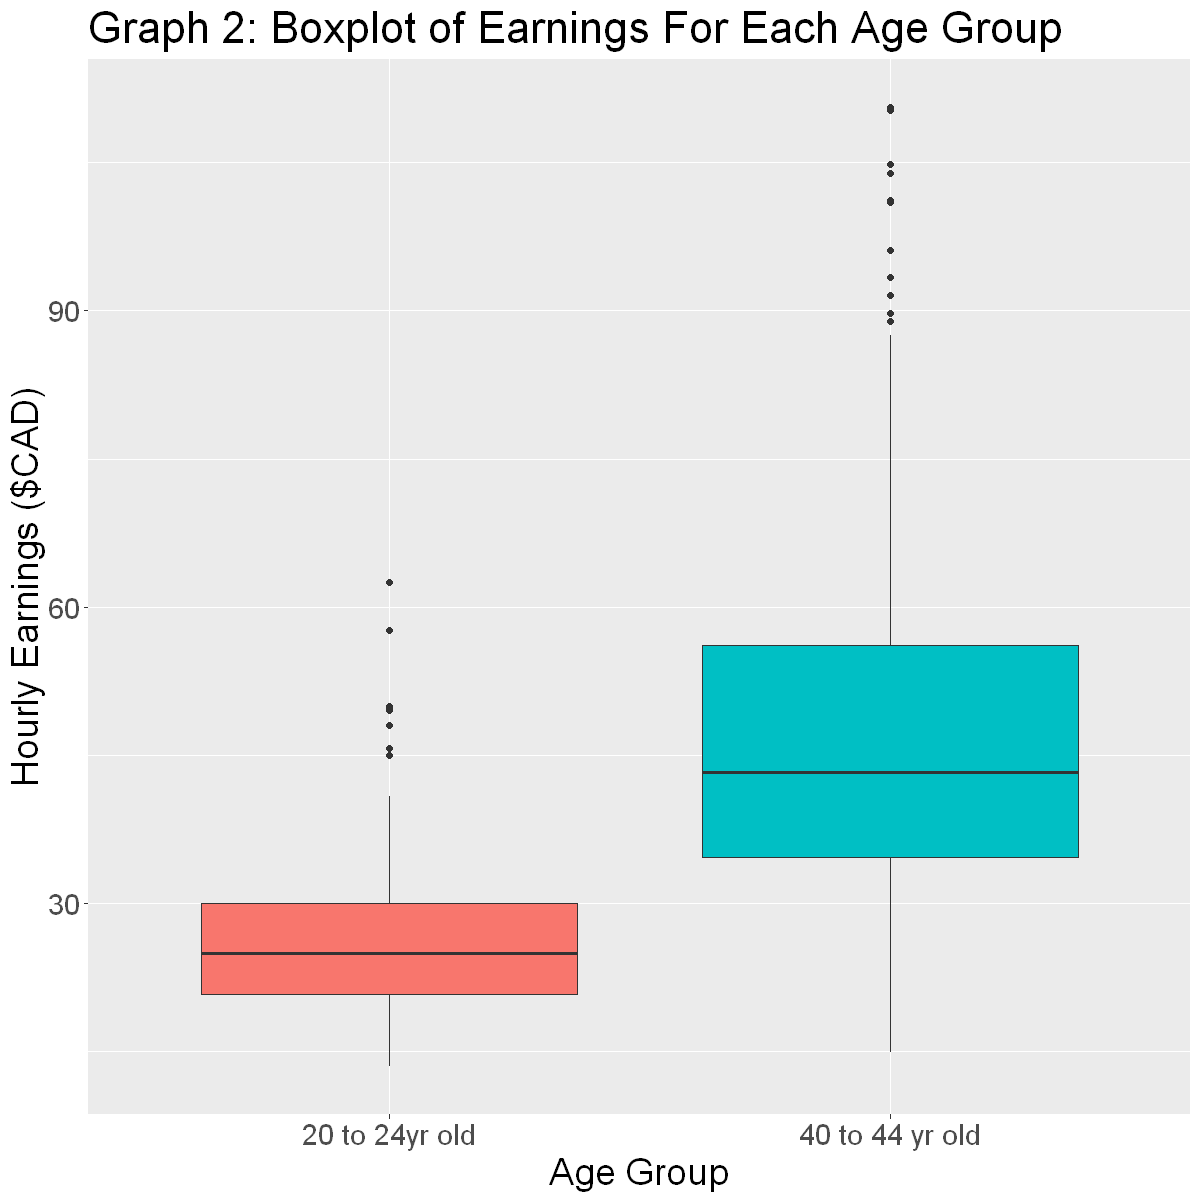

In [8]:
age_vs_wage_boxplots <-
    employment_clean %>% 
    ggplot() +
    geom_boxplot(aes(x=age_group, y=hourly_wage, fill = age_group)) +
    theme(text = element_text(size = 22)) +
    ggtitle("Graph 2: Boxplot of Earnings For Each Age Group") + 
    xlab("Age Group") + 
    ylab("Hourly Earnings ($CAD)") + 
    guides(fill = "none")
age_vs_wage_boxplots

### Methodology ###

We refer to s1 as the sample of workers in age group 20-24, s2 is the sample with workers in age group 40-44, and μ as the “mean wage”. As this investigation involves two independent datasets of different sizes, the two-sample t-test will be used with the following null hypothesis, $H_0$: $\mu_2$ - $\mu_1$ = 0, and the alternate hypothesis, $H_1: \mu_2 - \mu1 > 0$. By conducting the t-test to obtain the test statistic:

$$
T = \frac{\bar{x}-\bar{y} - d_0}{\sqrt{\frac{s_1^2}{n_1} + \frac{s_2^2}{n_2}} }
$$

Along with the degrees of freedom under the null model:

$$
\nu = \frac{
    \left(\frac{s_1^2}{n_1}+\frac{s_2^2}{n_2}\right)^2
}
{
\frac{s_1^4}{n_1^2(n_1-1)}+\frac{s_2^4}{n_2^2(n_2-1)}
}
$$

The aforementioned test statistics can be used to produce a p-value which will determine the validity of the null hypothesis under a 5% significance level. Visualizations of the t-distribution can be produced with ggplot to approximate the sampling distribution. Normality was assessed for each age group and visual inspections suggest that both distributions are normal. Hence, the null model is valid for all sample size and we do not need to rely on the CLT. The test will be conducted Asymptotically. Randomness of data can be ensured as phone call surveys were randomly made to different people to collect information on the occupation and personal information. In terms of independence of data, the responses of each individual age group would not affect each other. Although some may argue that people with lower income may be less likely to disclose their salary and occupation information and result in a violation of the independence of data, the each individual was surveyed anonymously and independently. It minimized the chance that participants would feel embarrassed to disclose their salary information or be affected under a group survey setting. In terms of the similar level of variability of data we can look at the standard deviation values. The sd values for the age groups of 20 - 24 and 40 - 44 is approximately 8 and 17 dollars (Table 3). Comparing it with the wage of the age groups, the difference is relatively mild; therefore, we believe that a 9 dollar difference in standard deviation is within a controlled range. As a result all of the conditions and assumptions of the two sample t test has been satisfied for us to continue with the hypothesis testing.

### Results ###

Let $x$ denote the 20 to 24 year old age group and $y$ denote the 40 to 44 year old group. Then we calculate the mean hourly wage denoted by $\bar{x}$ and $\bar{y}$, along with the variance. Note that $d_0 = 0$ because the null hypothesis is $\mu_2$ - $\mu_1 = 0$. Then using the formulas above, we find the degrees of freedom for our test and calculate the T-value of -22.16.

Then we find the standard error and calculate the 95% confidence interval.

In [9]:
age20to24 <- employment_clean %>% 
    filter(age_group == "20 to 24yr old")

age40to44 <- employment_clean %>% 
    filter(age_group == "40 to 44 yr old")

xbar <- mean(age20to24$hourly_wage)
ybar <- mean(age40to44$hourly_wage)

xVar <- var(age20to24$hourly_wage)
yVar <- var(age40to44$hourly_wage)

xn <- length(age20to24$hourly_wage)
yn <- length(age40to44$hourly_wage)

v <- ((xVar/xn)+(yVar/yn))^2 / ((xVar^2/((xn^2)*(xn-1)) + yVar^2/((yn^2)*(yn-1))))


T <- (xbar-ybar)/sqrt(xVar/xn+yVar/yn)
cat("T value:",T, "\n")

p_value <- pt(T, v)
cat("P Value:", p_value)

T value: -22.15625 
P Value: 1.153059e-84

In [10]:
se = sqrt((xVar/xn)+(yVar/yn))

age_mean_ci <- tibble(lower_ci = (xbar-ybar)+qt(0.025, v)*se,
                      upper_ci = (xbar-ybar)+qt(0.975, v)*se)
age_mean_ci

lower_ci,upper_ci
<dbl>,<dbl>
-21.05393,-17.62676


**Table 4: Confidence Interval of T-test**

Using the t.test function, we generate a table that includes the estimate, test statistic, and the p-value to confirm our findings above. We obtain a p-value of 1.15e-84, which is the probability of observing a test statistic at least as extreme as the observed test statistic, given that the null hypothesis is true. Since p < 0.05, we reject the null hypothesis, given that there is sufficient evidence supporting that the difference in means is greater than zero.

In [11]:
tidy(
    t.test(
            x = pull(filter(employment_clean, age_group == "20 to 24yr old"), hourly_wage),
            y = pull(filter(employment_clean, age_group == "40 to 44 yr old"), hourly_wage),
            alternative = "less"
    ))

estimate,estimate1,estimate2,statistic,p.value,parameter,conf.low,conf.high,method,alternative
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>
-19.34034,26.71486,46.0552,-22.15625,1.153059e-84,762.8401,-Inf,-17.90279,Welch Two Sample t-test,less


**Table 5: t.test result**

To supplement our findings from using asymptomatics, we will generate the bootstrap null distribution using 5000 replicates to find the sampling distribution of our test statistic assuming $\mu_2$ - $\mu_1 = 0$. We do this to simulate how the difference in means vary due to sampling under the null hypothesis.

In [12]:
set.seed(1)
null_model_wage <- employment_clean |>
                    specify(formula = hourly_wage ~ age_group) |>
                    generate(reps = 5000, type = "bootstrap") |>
                    calculate(stat = "diff in means", order = c("20 to 24yr old", "40 to 44 yr old"))

head(null_model_wage)

replicate,stat
<int>,<dbl>
1,-19.29264
2,-19.07819
3,-20.18498
4,-20.52439
5,-18.72715
6,-19.67712


**Table 6: Bootstrap Null Model of Wage**

Using a 95% confidence level to create the confidence interval of the null distribution. We are 95% confident that the true difference in means is captured by this interval.

In [13]:
bootstrap_ci <- 
    null_model_wage %>% 
    summarise(lower_ci = quantile(stat,0.025), upper_ci = quantile(stat,0.975))
bootstrap_ci

lower_ci,upper_ci
<dbl>,<dbl>
-21.03613,-17.59233


**Table 7: Confidence Interval of Null Model**

We visualize the distribution of our bootstrap by generating the histogram of our null model. The shaded region identifies all the values that fall within the 95% confidence interval. 

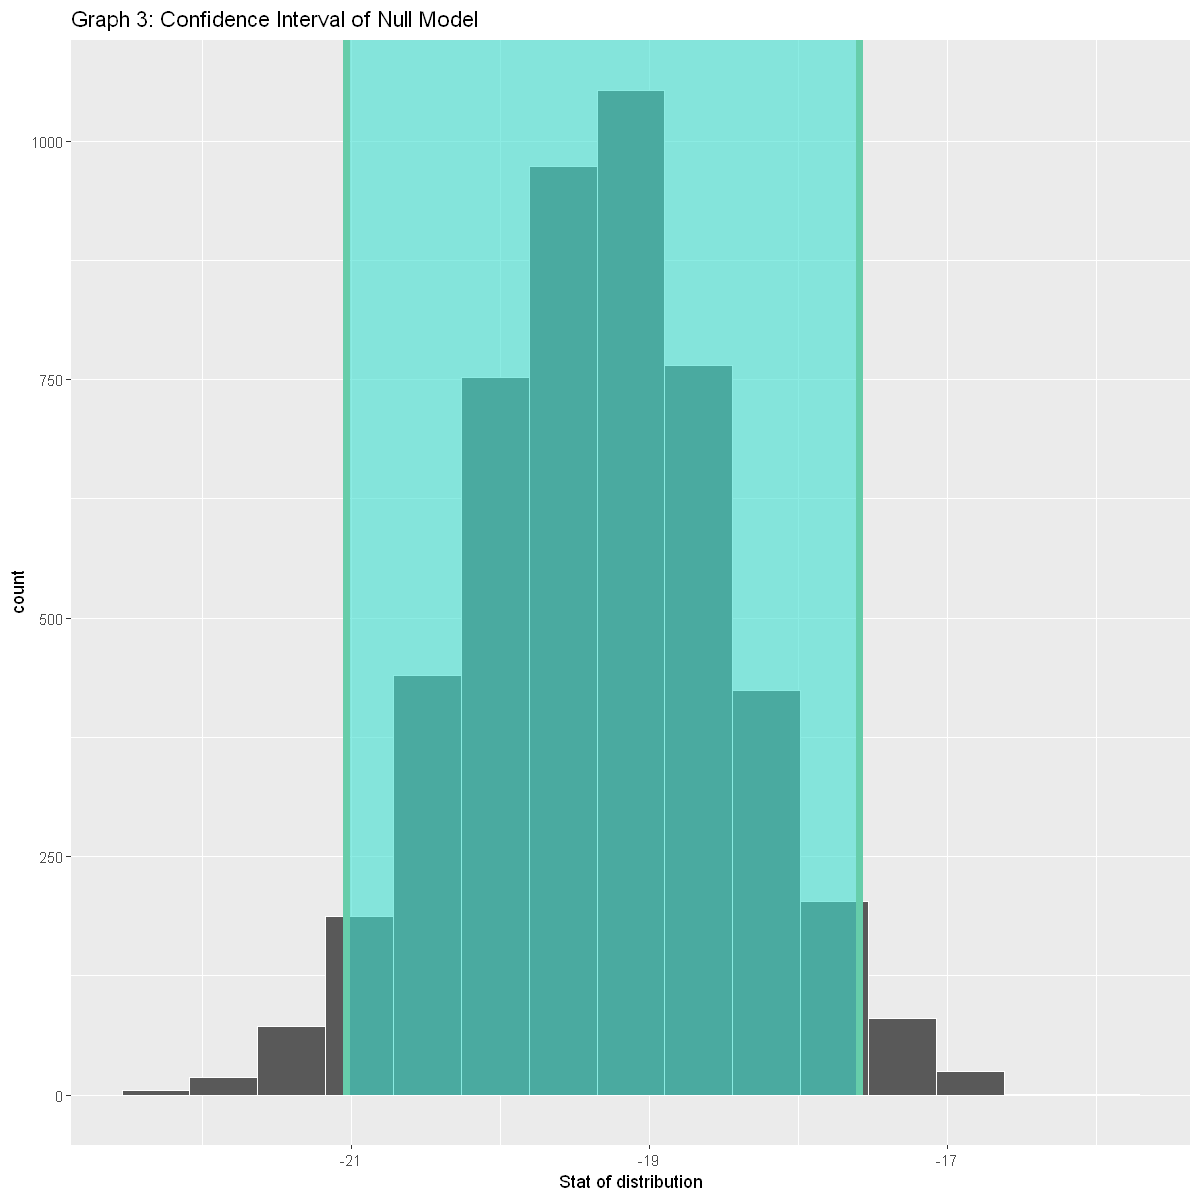

In [14]:
bootstrap_plot <- 
    null_model_wage %>%
    visualize() +
    shade_confidence_interval(bootstrap_ci)+
    xlab("Stat of distribution")+
    ggtitle("Graph 3: Confidence Interval of Null Model")
bootstrap_plot

## Discussion ##

In [15]:
table7 <- data.frame(T_value=T,
                 P_value=pt(T,v,lower.tail=TRUE),
                 lower_ci=age_mean_ci[1],
                 upper_ci=age_mean_ci[2],
                    lower_ci_Bootstrap = bootstrap_ci[1],
                    upper_ci_Bootstrap = bootstrap_ci[2])
colnames(table7) <- c("T value", 
                      "P value",
                      "T test Lower Confidence Interval",
                      "T test Upper Confidence Interval",
                      "Bootstrap Lower Confidence Interval",
                      "Bootstrap Upper Confidence Interval")
table7




T value,P value,T test Lower Confidence Interval,T test Upper Confidence Interval,Bootstrap Lower Confidence Interval,Bootstrap Upper Confidence Interval
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
-22.15625,1.153059e-84,-21.05393,-17.62676,-21.03613,-17.59233


**Table 8: Table of Results**

### Summary and Results ### 

Based off our two-sample t-test at a 5% significance level, we obtained a p-value of 1.15e-84 (Table 8), much lower than our significance level. It suggests strong evidence for us to reject our null hypothesis of $H_0$: $\mu_2$ - $\mu_1$ = 0 in favor of the alternative. In other words, the p-value indicates that the observed difference in mean hourly wages between workers with STEM occupations aged 20-24 and workers aged 40-44 is highly unlikely to have occurred by chance alone. The t-value measures the standard error and the sample mean difference in relation to the null hypothesis. It being a large negative value ,-22.16 (Table 8), indicates that the mean hourly wage of the 20-24 age group with STEM occupation is significantly lower than the mean hourly wage for workers aged 40-44 with STEM occupations. The confidence interval we calculated for the two-sample t test indicates the range of value the true population parameter is likely to fall within. In our scenario, it indicates that we can be 95% confident that the true mean difference in hourly wages between the two age groups lies between -21.04 and -12.59 dollars (Table 8), which is consistent with the finding and rejection of the null hypothesis.

We obtained a large t-value and used it to generate the confidence interval and find the p-value. Our observed test statistic was captured by the interval and our p-value is less than the significance level, suggesting that there is a significant difference in the means. However, we also want to test the variability. Hence, we generated a bootstrap of our data with 5000 replicates, and obtained a tighter confidence interval without changing the confidence level. In a similar fashion to our previous test findings, the 95% confidence interval of the null distribution as seen from graph 3 indicates that the mean difference between the two age groups is between 17.63 and 21.05 dollars (Table 8). This stark difference in mean salary further indicates that there is a disparity between the two groups and since the interval is negative it suggests that the age group 20-24 is making less than age group 40-44.

We think asymptotics is more appropriate because we have a large sample size with two different independent groups. We also do not have the population mean nor standard deviation for a bootstrap test. The bootstrap mean we obtained from the null model is centred at our observed mean. However, there is a significant difference in the 95% confidence interval that was generated. The asymptotic method is more trustworthy in obtaining the p-value, but the bootstrap is advantages in calculating the confidence interval.

### Expected Outcome ###

We expected to find a significant difference between the workers’ incomes of the two age groups, with the older generation having a higher income with a big difference. Industries value work experience, and people of older age having a stronger resume compared to the younger group being introduced to the workforce. Individuals also gain the opportunity to advance in their company with experience. Additionally, it is more difficult for the older group to have a higher mean by chance due to having a larger sample size. Hence, it further supports our expectations that the older group has a higher income.

### Significance and Impact ###

Knowing the income of different age groups can give insight to the longevity an individual has in the workforce. Our data gives an estimation of how much an individual is worth at their age range. Workers can approximate their value and negotiate their wage accordingly. This aids individuals in recognizing if they’re underpaid in comparison to their counterparts. Understanding the wage differences across various age groups can shed light on the changing dynamics of the labor market. The observed disparities in hourly wages may reflect variations in skills, experience, job roles, and demand for specific age cohorts. This information can be valuable for policymakers, employers, and workers in formulating strategies related to employment, training, and workforce development.

### Future Questions ###

After we conclude on this inferential question, we can further look at more specific questions. Such as: is the difference in hourly wage amongst the age groups constant between different major cities across Canada, or do they deviate? In which we can gain more insights about what types of jobs may largely depend on the experience of individuals. Moreover, many students choose to enter a trade workforce coming out of high school. They are likely to enter the workforce faster than university students and gain more experience.  How do the wages compare between workers in trades and workers in STEM across different age groups? Additionally, many higher level jobs pay by salary and don’t have set work hours, which doesn’t account for a portion of the population. Is the difference in salary significant amongst these age groups? The outcomes of this investigation can serve as a foundation for future research and economic studies. Researchers can delve deeper into the factors driving wage disparities, the role of education and experience, and potential gender or industry-related variations.


## References ##

Canada,. (2023). The Daily — Consumer Price Index, June 2023. Statcan.gc.ca. https://www150.statcan.gc.ca/n1/daily-quotidien/230718/dq230718a-eng.htm?HPA=1&indid=3665-1&indgeo=0  


O’Rourke, B. (2021, November 18). Increasing access and opportunity in STEM crucial, say experts. Harvard Gazette; Harvard Gazette. https://news.harvard.edu/gazette/story/2021/11/increasing-access-and-opportunity-in-stem-crucial-say-experts/


Tilo, Dexter. “31% of Canadians Have Never Tried to Negotiate Salary.” HRD Canada, 22 July 2022, www.hcamag.com/ca/specialization/employment-law/31-of-canadians-have-never-tried-to-negotiate-salary/414171. https://www.hcamag.com/ca/specialization/employment-law/31-of-canadians-have-never-tried-to-negotiate-salary/414171